In [26]:
import os
import requests
import pandas as pd
import glob
import geopandas as gpd
import mpl_toolkits.basemap
import matplotlib.pyplot as plt
from shapely.geometry import Point
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy
import scipy.stats
import seaborn
import sklearn.model_selection
import sklearn.neighbors
seaborn.set()

In [30]:
df1 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2020_9_2020_10_filtered.csv")
df2 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2020_11_2020_12_filtered.csv")
df3 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2021_1_2021_2_filtered.csv")
df4 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2021_3_2021_4_filtered.csv")
df5 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2021_5_2021_6_filtered.csv")
df6 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2021_7_2021_8_filtered.csv")
df7 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2021_9_2021_10_filtered.csv")
df8 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2021_11_2021_12_filtered.csv")
df9 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2022_1_2022_2_filtered.csv")
df10 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2022_3_2022_4_filtered.csv")
df11 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2022_5_2022_6_filtered.csv")
df12 = pd.read_csv("earthquake_contiguous_usa_12batch/Earthquake_2022_7_2022_8_filtered.csv")

batch = [pd.concat([df1, df2, df3]), pd.concat([df2, df3, df4]), pd.concat([df3, df4, df5]), pd.concat([df4, df5, df6]), pd.concat([df5, df6, df7]), pd.concat([df6, df7, df8]), pd.concat([df7, df8, df9]), pd.concat([df8, df9, df10]), pd.concat([df9, df10, df11]), pd.concat([df10, df11, df12])]
print('number of batches: ' + str(len(batch)))

number of batches: 10


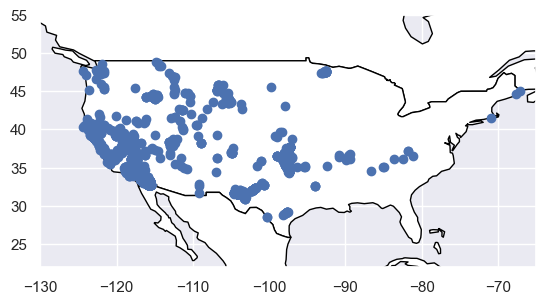

In [33]:
#choose batch from 0 - 9
df = batch[1]

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')
plt.xlim([-130,-65])
plt.ylim([22,55])
gdf.plot(ax=ax)

plt.show()

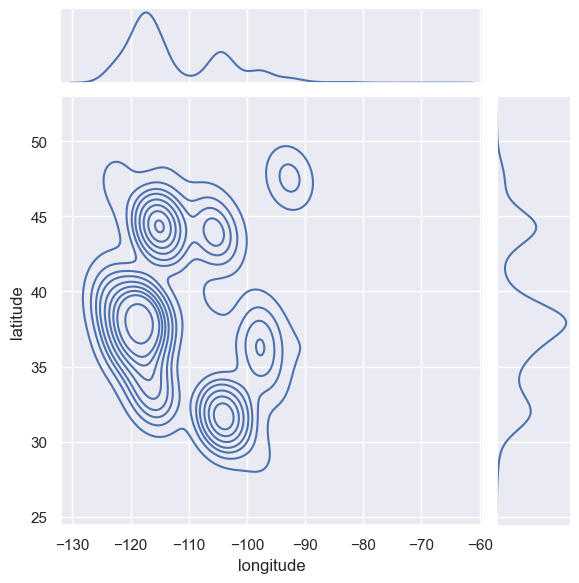

In [34]:
df_all = df[['latitude', 'longitude']]

seaborn.jointplot(df_all, x="longitude", y="latitude", kind="kde")

In [41]:
# set up the data grid for the contour plot
xgrid = numpy.sort(list(df_all['longitude']))
ygrid = numpy.sort(list(df_all['latitude']))
x, y = numpy.meshgrid(xgrid, ygrid)
print("X Grid Component:\n{}\n".format(x))
print("Y Grid Component:\n{}\n".format(y))

# combine x and y grids into pairs
xy = numpy.vstack([y.ravel(), x.ravel()]).T

X Grid Component:
[[-124.38033333 -124.3585     -124.2291667  ...  -70.9546
   -67.6285      -67.1595    ]
 [-124.38033333 -124.3585     -124.2291667  ...  -70.9546
   -67.6285      -67.1595    ]
 [-124.38033333 -124.3585     -124.2291667  ...  -70.9546
   -67.6285      -67.1595    ]
 ...
 [-124.38033333 -124.3585     -124.2291667  ...  -70.9546
   -67.6285      -67.1595    ]
 [-124.38033333 -124.3585     -124.2291667  ...  -70.9546
   -67.6285      -67.1595    ]
 [-124.38033333 -124.3585     -124.2291667  ...  -70.9546
   -67.6285      -67.1595    ]]

Y Grid Component:
[[28.4727     28.4727     28.4727     ... 28.4727     28.4727
  28.4727    ]
 [28.5067749  28.5067749  28.5067749  ... 28.5067749  28.5067749
  28.5067749 ]
 [28.8387     28.8387     28.8387     ... 28.8387     28.8387
  28.8387    ]
 ...
 [48.60066667 48.60066667 48.60066667 ... 48.60066667 48.60066667
  48.60066667]
 [48.7652     48.7652     48.7652     ... 48.7652     48.7652
  48.7652    ]
 [48.8828     48.8828     

In [44]:
# run kernel density estimation
kde = sklearn.neighbors.KernelDensity(
    bandwidth=1, 
    metric='minkowski',
    kernel='gaussian', 
    algorithm='ball_tree'
)
kde.fit(df_all.values)

# fit the trained model on the xy grid
log_density = kde.score_samples(xy)
density = numpy.exp(log_density)
density = density.reshape(x.shape)
print("Shape of Density Values:\n{}\n".format(density.shape))

Shape of Density Values:
(1484, 1484)



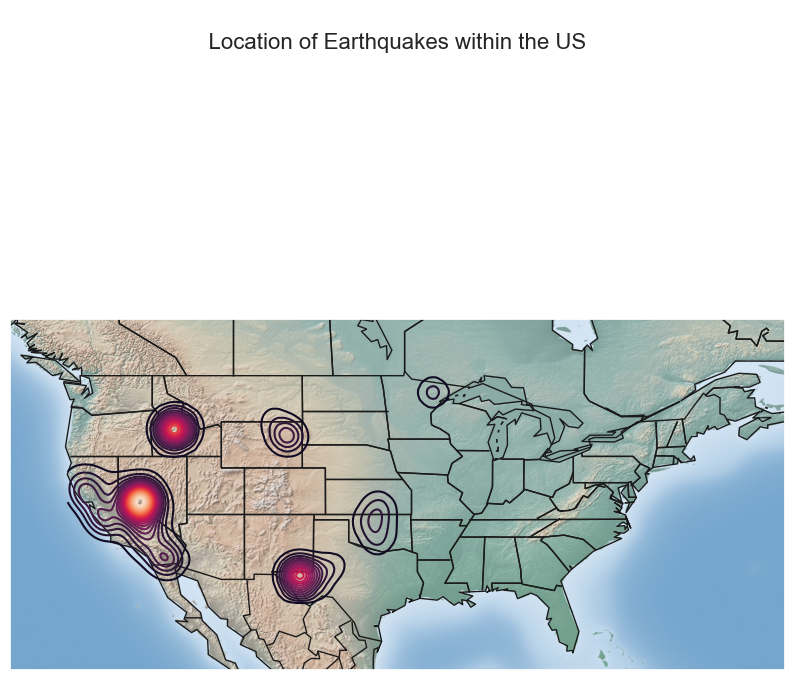

In [105]:
# visualize the results
fig15 = plt.figure(figsize=(10, 10))
fig15.suptitle(
    """
    Location of Earthquakes within the US
    """, 
    fontsize=16
)

the_map = mpl_toolkits.basemap.Basemap(
    projection='cyl',
    llcrnrlat=y.min()-5, urcrnrlat=y.max()+5,
    llcrnrlon=x.min()-5,urcrnrlon=x.max()+5,
    resolution='c'
)

the_map.drawcoastlines(linewidth=1)
the_map.drawcountries(linewidth=1)
the_map.drawstates(linewidth=1)
the_map.shadedrelief()

levels = numpy.linspace(0, density.max(), 25)
the_map.contour(x, y, density, levels=levels)
plt.show()